In [1]:
from dataclasses import replace
import random
from collections import Counter

from replenishment import (
    build_point_forecast_article_configs_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    compute_backtest_rmse_by_article,
    generate_standard_simulation_rows,
    optimize_aggregation_and_service_level_factors,
    optimize_service_level_factors,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    simulate_replenishment_for_articles,
    simulate_replenishment_with_aggregation,
    split_standard_simulation_rows,
    standard_simulation_rows_to_dataframe,
)

### Policy cadence parameters (review cycle + forecast horizon)

Set the order cadence (**review_period**) and the coverage window (**forecast_horizon**, excluding lead time).
The policy uses a total horizon of **lead_time + forecast_horizon**.


In [ ]:
review_period = 1
forecast_horizon = 1
rmse_window = review_period  # optional; defaults to review_period


# Mean Forecast: Fill Rate
This notebook treats `sigma` as a probability (cycle fill rate) and compares:  
1) optimizing sigma only,  
2) optimizing sigma + aggregation window.


## 1) Generate Sample Data
We generate synthetic history + forecast rows. Forecast periods are given simulated actuals so we can compare forecast vs. actuals in evaluation.


In [2]:

history_mean = 20.0
history_std = 8.0
forecast_mean = 18.0
forecast_std = 6.0

rows = generate_standard_simulation_rows(
    n_unique_ids=200,
    periods=120,
    history_mean=history_mean,
    history_std=history_std,
    forecast_mean=forecast_mean,
    forecast_std=forecast_std,
    forecast_start_period=60,
    lead_time=3,    
    initial_on_hand=25,
    current_stock=25,
    holding_cost_per_unit=1,
    stockout_cost_per_unit=5,
    order_cost_per_order=10,
)

backtest_rows, evaluation_rows = split_standard_simulation_rows(rows)

# Add simulated actuals for the forecast/evaluation period.
rng = random.Random(7)
def _sample_int(mean: float, std: float) -> int:
    return max(0, int(round(rng.gauss(mean, std))))

evaluation_rows_actuals = []
for row in evaluation_rows:
    actual = _sample_int(history_mean, history_std)
    evaluation_rows_actuals.append(replace(row, actuals=actual, demand=actual))

evaluation_rows = evaluation_rows_actuals

rows_df = standard_simulation_rows_to_dataframe(
    backtest_rows + evaluation_rows, library="pandas"
)
print(f"backtest rows: {len(backtest_rows)}, forecast rows: {len(evaluation_rows)}")
if not evaluation_rows:
    raise ValueError("No forecast rows found. Set forecast_start_period to create forecast rows.")

candidate_service_levels = [.1, .12, .14, .16, .18, .2, .22, .24, .26, .28, .3, .32, .34, .36, .38, .4, .42,  .5, 
                       .6, .62, .64, .66, .68, 0.7, .72, .74, .76, 
                       .78, 0.8, .82, .84, .86, .88, .90, .92, .94, .96, .99
                       ]
candidate_windows = [3, 6, 9]


backtest rows: 12000, forecast rows: 12000


## 2) Optimize Sigma Only (Fill Rate)


In [3]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows, rmse_window=rmse_window)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=candidate_service_levels[0],
    service_level_mode="fill_rate",
    fixed_rmse=backtest_rmse,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)

optimized = optimize_service_level_factors(
    point_configs,
    candidate_factors=candidate_service_levels,
    service_level_mode="fill_rate",
)

best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in optimized.items()
}

backtest_actuals = {}
for row in backtest_rows:
    backtest_actuals.setdefault(row.unique_id, []).append(row)
for unique_id, series in backtest_actuals.items():
    series.sort(key=lambda r: r.ds)
    backtest_actuals[unique_id] = [int(r.actuals) for r in series]

eval_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=best_factors,
    service_level_mode="fill_rate",
    fixed_rmse=backtest_rmse,
    actuals_override=backtest_actuals,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)
eval_simulations = simulate_replenishment_for_articles(eval_configs)
eval_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    eval_simulations,
    sigma=best_factors,
    fixed_rmse=backtest_rmse,
    service_level_mode="fill_rate",
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)


In [4]:
sigma_decisions_df = replenishment_decision_rows_to_dataframe(eval_decisions)
sigma_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2028-12-05,56,18,24,42,67.432038,91.432038,0,25,...,18.432038,25,7,7,56,0,0,0.96,1,None
1,A,2029-01-04,7,24,13,43,62.086729,75.086729,0,7,...,20.086729,7,0,0,63,0,17,0.96,1,None
2,A,2029-02-03,6,18,12,51,62.837483,74.837483,0,0,...,19.837483,0,0,0,69,0,18,0.96,1,None
3,A,2029-03-05,10,17,17,41,68.993925,85.993925,56,56,...,17.993925,56,39,39,23,0,0,0.96,1,None
4,A,2029-04-04,11,13,14,39,61.340773,75.340773,7,46,...,20.340773,46,33,33,27,0,0,0.96,1,None


0      0
1     17
2     18
3      0
4      0
5      0
6      0
7     10
8     13
9      0
10     0
11     7
12     0
13     0
14     0
15     2
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27    10
28     3
29    12
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     6
56     0
57     0
58     5
59     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

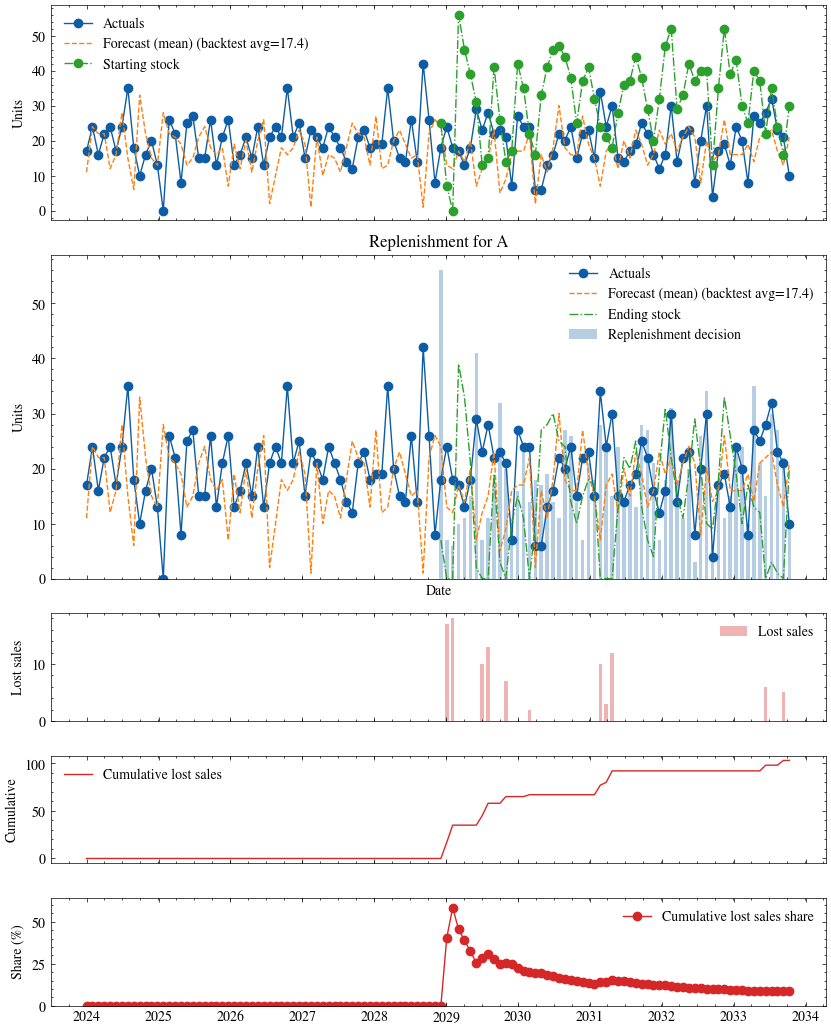

In [5]:
example_id = sigma_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, sigma_decisions_df, unique_id=example_id)


## 3) Optimize Sigma + Aggregation Window


In [6]:
candidate_windows

[3, 6, 9]

In [7]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows, rmse_window=rmse_window)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=.95,
    service_level_mode="fill_rate",
    fixed_rmse=backtest_rmse,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)

agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=candidate_windows,
    candidate_factors=candidate_service_levels,
    service_level_mode="fill_rate",
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}

agg_backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows,
    aggregation_window=agg_windows,
    rmse_window=rmse_window,
)

forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=agg_best_factors,
    service_level_mode="fill_rate",
    fixed_rmse=agg_backtest_rmse,
    actuals_override=backtest_actuals,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)
agg_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    agg_simulations,
    aggregation_window=agg_windows,
    sigma=agg_best_factors,
    fixed_rmse=agg_backtest_rmse,
    service_level_mode="fill_rate",
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)


In [8]:
agg_decisions_df = replenishment_decision_rows_to_dataframe(agg_decisions)
agg_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2028-12-05,113,18,16.333333,33.333333,124.095565,173.095565,0,25,...,75.095565,25,7,7,113,0,0,0.99,3,None
1,A,2029-01-04,0,24,14.000000,27.666667,119.492562,161.492562,0,7,...,77.492562,7,0,0,113,0,17,0.99,3,None
2,A,2029-02-03,0,18,14.333333,27.333333,120.129542,163.129542,0,0,...,77.129542,0,0,0,113,0,18,0.99,3,None
3,A,2029-03-05,23,17,17.000000,28.333333,125.466101,176.466101,113,113,...,74.466101,113,96,96,23,0,0,0.99,3,None
4,A,2029-04-04,0,13,13.666667,30.333333,118.863279,159.863279,0,96,...,77.863279,96,83,83,23,0,0,0.99,3,None


0      0
1     17
2     18
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     7
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     0
56     0
57     0
58     0
59     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

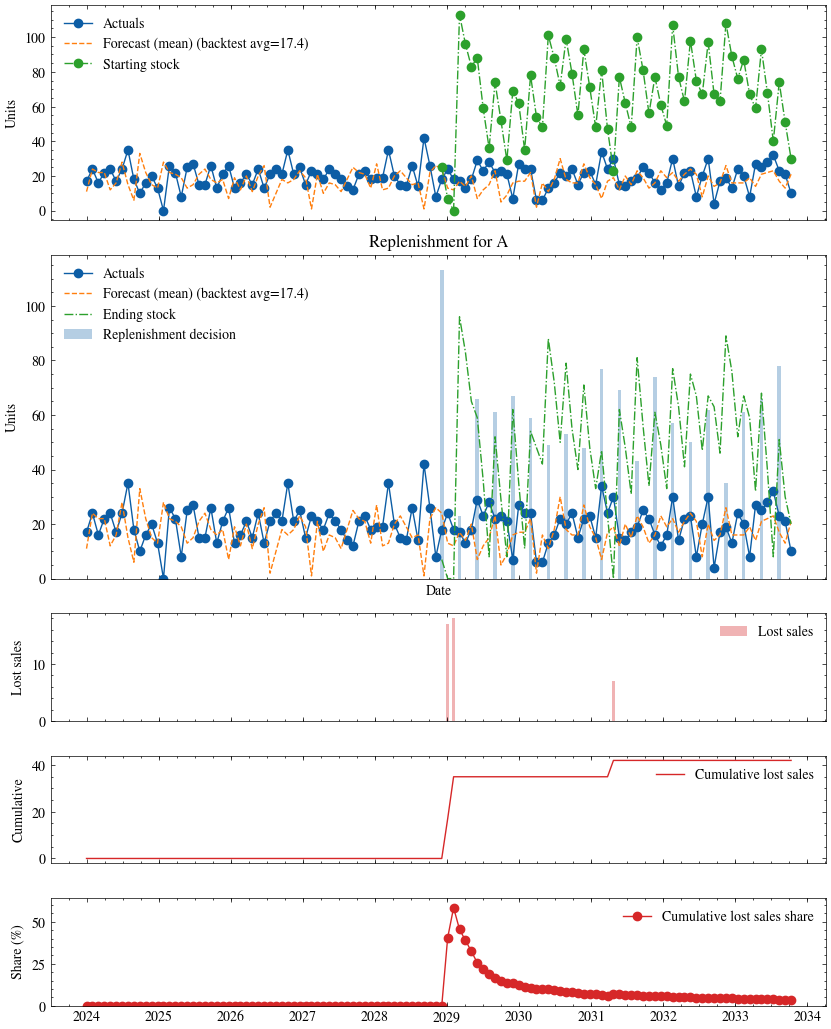

In [9]:
example_id = agg_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, agg_decisions_df, unique_id=example_id)


### Take a given fill rate and optimize aggregation windows

In [10]:
candidate_windows

[3, 6, 9]

In [11]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows, rmse_window=rmse_window)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=.95,
    service_level_mode="fill_rate",
    fixed_rmse=backtest_rmse,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)

agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=candidate_windows,
    candidate_factors=[.95],
    service_level_mode="fill_rate",
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}

agg_backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows,
    aggregation_window=agg_windows,
    rmse_window=rmse_window,
)

forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=agg_best_factors,
    service_level_mode="fill_rate",
    fixed_rmse=agg_backtest_rmse,
    actuals_override=backtest_actuals,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)
agg_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    agg_simulations,
    aggregation_window=agg_windows,
    sigma=agg_best_factors,
    fixed_rmse=agg_backtest_rmse,
    service_level_mode="fill_rate",
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)


0      0
1     17
2     18
3      0
4      0
5      0
6      0
7      0
8     19
9      0
10     0
11     1
12     0
13     0
14    14
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     4
29    30
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     0
56    21
57     0
58     0
59     0
Name: missed_sales, dtype: int64


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2028-12-05,85,18,16.333333,33.333333,95.779044,144.779044,0,25,...,46.779044,25,7,7,85,0,0,0.95,3,None
1,A,2029-01-04,0,24,14.000000,27.666667,91.810148,133.810148,0,7,...,49.810148,7,0,0,85,0,17,0.95,3,None
2,A,2029-02-03,0,18,14.333333,27.333333,92.352779,135.352779,0,0,...,49.352779,0,0,0,85,0,18,0.95,3,None
3,A,2029-03-05,24,17,17.000000,28.333333,96.978615,147.978615,85,85,...,45.978615,85,68,68,24,0,0,0.95,3,None
4,A,2029-04-04,0,13,13.666667,30.333333,91.276606,132.276606,0,68,...,50.276606,68,55,55,24,0,0,0.95,3,None


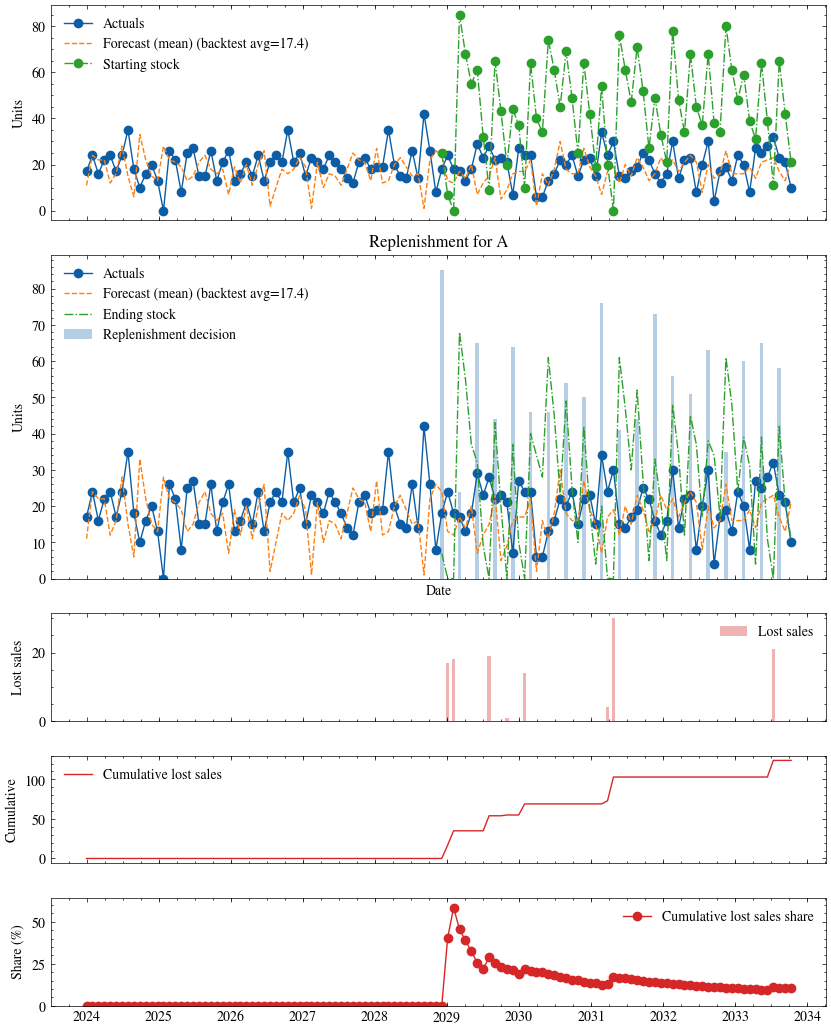

In [12]:
agg_decisions_df = replenishment_decision_rows_to_dataframe(agg_decisions)

example_id = agg_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, agg_decisions_df, unique_id=example_id)

agg_decisions_df.head()

In [13]:
agg_decisions_df[agg_decisions_df.ds > '2026-06-19']['missed_sales'].sum()

np.int64(21134)

In [14]:
agg_decisions_df[agg_decisions_df.ds > '2026-06-19']['demand'].sum()

np.int64(240519)

In [15]:
21234 / 240519

0.08828408566474998